In [1]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [2]:
import numpy as np
import pandas as pd
from itertools import product
from sklearn.model_selection import train_test_split
from src.optimizers import *
from src.activation_functions import * 
from src.utils import *
from src.model_regularization import *
from src.layer import *
np.random.seed(0)


#### Data pre-processing for MONK Datasets 

In [3]:
########################################################
### Don't forget to change the path to the data file ###
########################################################

df = pd.read_csv("../ML_project/data/Monk_3/monks-3.train", names=[0,1,2,3,4,5,6,"index"], delimiter= " ")
# df = pd.read_csv("../ML_project/data/Monk_2/monks-2.train",
#                  names=[0, 1, 2, 3, 4, 5, 6, "index"], delimiter=" ")
df.set_index("index", inplace=True)
y = df.iloc[:, 0]  # First column as target
X = df.iloc[:, 1:]  # All other columns as features
for i in range(1, X.shape[1]):
    X.iloc[:, i] = (X.iloc[:, i] - np.mean(X.iloc[:, i])) / \
        np.std(X.iloc[:, i])
X.head()

C:\Users\Mostafa\AppData\Local\Temp\ipykernel_15816\2770782428.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'index
data_2     -1.255411
data_3     -1.255411
data_4     -1.255411
data_5     -1.255411
data_7     -1.255411
              ...   
data_420    1.214913
data_422    1.214913
data_425    1.214913
data_430    1.214913
data_432    1.214913
Name: 2, Length: 122, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.iloc[:, i] = (X.iloc[:, i] - np.mean(X.iloc[:, i])) / \
C:\Users\Mostafa\AppData\Local\Temp\ipykernel_15816\2770782428.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'index
data_2     -0.936442
data_3     -0.936442
data_4     -0.936442
data_5     -0.936442
data_7     -0.936442
              ...   
data_420    1.067872
data_422    1.067872
data_425    1.067872
data_43

,1,2,3,4,5,6
index,,,,,,
data_2,1,-1.255411,-0.936442,-1.245633,-1.302980,0.967733
data_3,1,-1.255411,-0.936442,-1.245633,-0.419849,-1.033342
data_4,1,-1.255411,-0.936442,-1.245633,-0.419849,0.967733
data_5,1,-1.255411,-0.936442,-1.245633,0.463282,-1.033342
data_7,1,-1.255411,-0.936442,-1.245633,1.346413,-1.033342


In [4]:
########################################################
### Don't forget to change the path to the data file ###
########################################################

test_data = pd.read_csv("../ML_project/data/Monk_3/monks-3.test",
names=[0, 1, 2, 3, 4, 5, 6, "index"], delimiter=" ")
test_data.set_index("index", inplace=True)
# test_data.head()
y_test = test_data.iloc[:, 0]
X_test = test_data.iloc[:, 1:]
for i in range(1, X_test.shape[1]):
    X_test.iloc[:, i] = (X_test.iloc[:, i] - np.mean(X_test.iloc[:, i])) / np.std(X_test.iloc[:, i])

C:\Users\Mostafa\AppData\Local\Temp\ipykernel_15816\2279363569.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'index
data_1     -1.224745
data_2     -1.224745
data_3     -1.224745
data_4     -1.224745
data_5     -1.224745
              ...   
data_428    1.224745
data_429    1.224745
data_430    1.224745
data_431    1.224745
data_432    1.224745
Name: 2, Length: 432, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.iloc[:, i] = (X_test.iloc[:, i] - np.mean(X_test.iloc[:, i])) / np.std(X_test.iloc[:, i])
C:\Users\Mostafa\AppData\Local\Temp\ipykernel_15816\2279363569.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'index
data_1     -1.0
data_2     -1.0
data_3     -1.0
data_4     -1.0
data_5     -1.0
           ... 
data_428    1.0
data_429    1.0
data_430    1.0
data_431    1

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the resulting datasets
print("Training Features Shape:", X_train.shape)
print("Validation Features Shape:", X_val.shape)
print("Training Target Shape:", y_train.shape)
print("Validation Target Shape:", y_val.shape)

Training Features Shape: (97, 6)
Validation Features Shape: (25, 6)
Training Target Shape: (97,)
Validation Target Shape: (25,)


In [6]:
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        if len(y_true.shape) == 1:
            correct_confidence = y_pred_clipped[range(samples), y_true]

        elif len(y_true.shape) == 2:
            correct_confidence = np.sum(y_pred_clipped * y_true, axis=1) 

        negative_log_likelihoods = np.log(correct_confidence)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


class Activation_Softmax_Loss_CategoricalCrossentropy():

    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()


    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)

        # Set the output
        self.output = self.activation.output

        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()

        self.dinputs[range(samples), y_true] -= 1

        self.dinputs = self.dinputs / samples

class MSE:
    def __init__(self):
        self.dinputs = None
        self.output = None
        
    def forward(self, y_pred, y_true):
        # Remove the shape condition - always calculate loss
        self.output = np.mean((y_pred - y_true)**2)
        return self.output
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        self.dinputs = 2 * (dvalues - y_true) / samples

In [7]:
class NN:
    def __init__(self, l1, l2, input_size, hidden_sizes, output_size, 
                 hidden_activations=None, dropout_rates=None, output_activation=Activation_Sigmoid()):
        self.layers = []
        prev_size = input_size
        
        # Default to ReLU if no activations specified
        if hidden_activations is None:
            hidden_activations = [Activation_ReLU() for _ in hidden_sizes]
        
        # Default to no dropout
        if dropout_rates is None:
            dropout_rates = [0.0] * len(hidden_sizes)
            
        # Create hidden layers
        for size, activation, rate in zip(hidden_sizes, hidden_activations, dropout_rates):
            self.layers.append(Layer_Dense(prev_size, size,l1=l1, l2=l2))
            self.layers.append(activation())
            if rate > 0:
                self.layers.append(Dropout(rate))
            prev_size = size
        
        # Output layer (no activation)
        self.layers.append(Layer_Dense(prev_size, output_size))
        # self.layers.append(output_activation)
        
    def forward(self, inputs, training=True):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                layer.forward(inputs, training)
            else:
                layer.forward(inputs)
            inputs = layer.output
        self.output = inputs

In [8]:
def accuracy(target, output):
    predictions = np.round(output.squeeze())
    return np.mean(predictions == target.squeeze()) * 100

In [22]:
def train_and_evaluate(learning_rate, l1, l2, dropout_rate, batch_size, activation, n_epochs=500):
    # Initialize components
    model = NN(
        l1=l1,
        l2=l2,
        input_size=6,
        hidden_sizes=[10],
        output_size=1,
        hidden_activations=[activation],
        dropout_rates=[dropout_rate],
        output_activation=Activation_Sigmoid()
    )
    
    loss_function = MSE()
    optimizer = Optimizer_Adam(learning_rate=learning_rate, decay=1e-3)
    early_stopping = EarlyStopping(
        patience=20,
        min_delta_loss=0.0001,
        min_delta_accuracy=0.0001
    )

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(n_epochs):
        # Training phase
        batch_losses = []
        batch_accuracies = []
        
        for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
            # Forward pass
            model.forward(X_batch, training=True)
            
            # Calculate loss and accuracy
            loss = loss_function.forward(model.output, y_batch)
            predictions = np.round(model.output.squeeze())
            accuracy = np.mean(predictions == y_batch.squeeze())

            # Backward pass
            loss_function.backward(model.output, y_batch)
            dvalues = loss_function.dinputs
            
            # Gradient propagation
            for layer in reversed(model.layers):
                layer.backward(dvalues)
                dvalues = layer.dinputs
                # Convert pandas objects to numpy arrays
                if isinstance(dvalues, (pd.DataFrame, pd.Series)):
                    dvalues = dvalues.values

            # Parameter update
            optimizer.pre_update_params()
            for layer in model.layers:
                if isinstance(layer, Layer_Dense):
                    optimizer.update_params(layer)
            optimizer.post_update_params()
            
            batch_losses.append(loss)
            batch_accuracies.append(accuracy)

        # Store epoch metrics
        epoch_loss = np.mean(batch_losses)
        epoch_acc = np.mean(batch_accuracies)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation phase
        model.forward(X_val.values if isinstance(X_val, pd.DataFrame) else X_val, 
                     training=False)
        val_loss = loss_function.forward(model.output, 
                                        y_val.values if isinstance(y_val, (pd.Series, pd.DataFrame)) else y_val)
        val_predictions = np.round(model.output.squeeze())
        val_accuracy = np.mean(val_predictions == y_val.squeeze())
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Early stopping check
        early_stopping.on_epoch_end(val_loss, val_accuracy, model, epoch)
        if early_stopping.stop_training:
            print(f"\nEarly stopping triggered at epoch {epoch}! Restoring best weights from epoch {early_stopping.best_epoch}")
            break

        # Progress reporting
        if epoch % 10 == 0:  # More frequent updates
            print(f"Epoch {epoch}: ", end="")
            print(f"Train Loss: {epoch_loss}, Acc: {epoch_acc*100} % | ", end="")
            print(f"Val Loss: {val_loss}, Acc: {val_accuracy*100} % ")

    # Restore best weights if any improvement occurred
    if early_stopping.best_weights is not None:
        for i, layer in enumerate(model.layers):
            if isinstance(layer, Layer_Dense):
                layer.weights = early_stopping.best_weights[i][0].copy()
                layer.bias = early_stopping.best_weights[i][1].copy()

    # Final validation with restored weights
    model.forward(X_val.values if isinstance(X_val, pd.DataFrame) else X_val, training=False)
    final_val_loss = loss_function.forward(model.output, y_val.values if isinstance(y_val, (pd.Series, pd.DataFrame)) else y_val)
    final_val_accuracy = np.mean(np.round(model.output.squeeze()) == y_val.squeeze())

    return final_val_loss, final_val_accuracy

In [23]:
hyperparameter_grid = {
    'learning_rate': [0.01, 0.003, 0.0005],
    'l1': [0.0, 1e-5],
    'l2': [0.0, 1e-4, 1e-3],
    'dropout_rate': [0.2, 0.5],
    'batch_size': [1, 4, 16, 32],
    'activation': [Activation_Leaky_ReLU, Activation_Tanh]
}

# hyperparameter_grid = {
#     'learning_rate': [0.1],
#     'l1': [0.0, 1e-5],
#     'l2': [0.0, 1e-4],
#     'dropout_rate': [0.1,],
#     'batch_size': [1,],
#     'activation': [Activation_Sigmoid]
# }

In [24]:
# print(len(val_accuracies))

In [25]:
# Initialize variables to store the best hyperparameters and performance
best_hyperparams = []
best_performance = (-np.inf, -np.inf)  # Assuming we are maximizing validation accuracy

# Iterate over all combinations of hyperparameters
for params in product(*hyperparameter_grid.values()):
    # Unpack the hyperparameters
    learning_rate, l1, l2, dropout_rate, batch_size, activation = params
    # Train and evaluate the model
    val_accuracy = train_and_evaluate(learning_rate, l1, l2, dropout_rate, batch_size, activation)
    # Update the best hyperparameters if the current model is better
    if val_accuracy[1] > best_performance[1]:
        best_hyperparams.clear()
        best_performance = val_accuracy
        best_hyperparams.append({
            'learning_rate': learning_rate,
            'l1': l1,
            'l2': l2,
            'dropout_rate': dropout_rate,
            'batch_size': batch_size,
            'activation': activation
        })
    elif val_accuracy[1] == 1.0:
        best_hyperparams.append({
            'learning_rate': learning_rate,
            'l1': l1,
            'l2': l2,
            'dropout_rate': dropout_rate,
            'batch_size': batch_size,
            'activation': activation
        })

# Print the best hyperparameters and performance
print("Best Hyperparameters:", best_hyperparams)
print("Best Validation Accuracy:", best_performance)

Epoch   0: 

ValueError: Invalid format specifier

In [49]:
print(best_hyperparams)

[{'learning_rate': 0.1, 'l1': 1e-05, 'l2': 0.0, 'dropout_rate': 0.1, 'batch_size': 4, 'n_epochs': 50, 'activation': <class 'src.activation_functions.Activation_Tanh'>}, {'learning_rate': 0.1, 'l1': 1e-05, 'l2': 0.0001, 'dropout_rate': 0.1, 'batch_size': 4, 'n_epochs': 400, 'activation': <class 'src.activation_functions.Activation_Tanh'>}]


In [50]:
test_accuracies = []

Data shapes:
X_train: (97, 6), y_train: (97,)
Sample prediction: None
Initial loss: 0.0015870019389909115
0.37235930942319184 0.61
0.18266389974871416 0.73
0.1363584777865964 0.81
0.14720183793290448 0.79
0.13795829225700093 0.81
0.09893543691536058 0.91
0.09747552113488522 0.94
0.09849958323847476 0.87
0.06943321071540465 0.95
0.08816762298672304 0.91
0.0689134472098262 0.94
0.06662889072739496 0.93
0.10838971312225254 0.88
0.07702517846864149 0.93
0.060748874876803687 0.94
0.072616703486494 0.91
0.08085515783076543 0.87
0.06518036653782727 0.94
0.05499565835880709 0.97
0.06063437436233299 0.96
0.08395784782574425 0.91
0.06850264746672238 0.94
0.08733818258917601 0.9
0.05782776439223594 0.95
0.0678124249191943 0.95
0.059678955648066676 0.94
0.05773406006930339 0.95
0.059032858721561915 0.95
0.06439075069147018 0.91
0.06049860066771344 0.95
0.08062608560166862 0.93
0.05856537827500764 0.93
0.06287757417612926 0.96
0.06376443092990593 0.91
0.05677670661140104 0.93
0.05071583135451751 0.

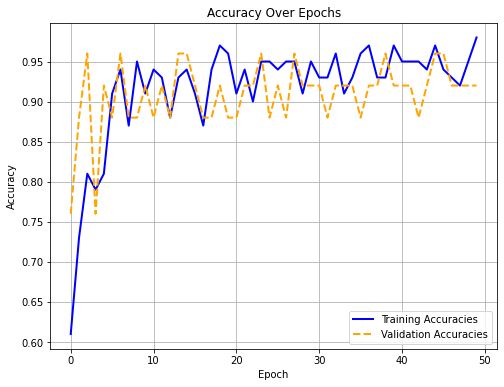

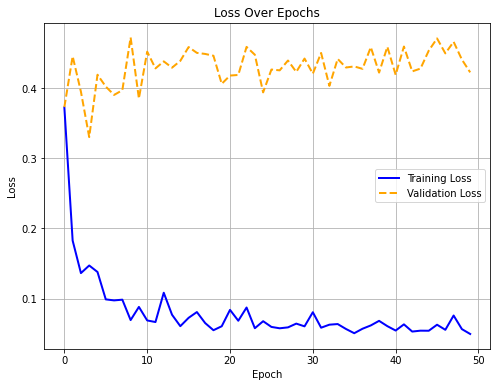

Test Accuracy: 0.9375


In [54]:
for i in best_hyperparams[:1]: 
    learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation = i.values()
    model = NN(
        l1=l1,
        l2=l2,
        input_size=6,
        hidden_sizes=[10],
        output_size=1,
        hidden_activations=[activation],
        dropout_rates=[dropout_rate]
    )
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # early_stopping = EarlyStopping(
    #     patience=20,
    #     min_delta_loss=0.0001,
    #     min_delta_accuracy=0.0001,
    #     restore_best_weights=True
    # )
    # loss_activation = MSE()
    loss_function = MSE()
    optimizer = Optimizer_Adam(learning_rate=learning_rate, decay=1e-2)
    # Before training loop:
    print("Data shapes:")
    print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Sample prediction: {model.forward(X_train[:1])}")  # Should output ~0.5
    print(f"Initial loss: {loss_function.forward(model.output, y_train[:1].squeeze())}")
    # Training loop
    for epoch in range(n_epochs):
        batch_losses = []
        batch_accuracies = []
        
        for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
            # Forward pass
            model.forward(X_batch, training=True)
            
            # Calculate loss
            loss = loss_function.forward(model.output, y_batch)
            
            predictions = np.round(model.output.squeeze())
            accuracy = np.mean(predictions == y_batch.squeeze())

            # Backward pass with shape validation
            loss_function.backward(model.output, y_batch)

            # max_grad = max(
            #     np.max(np.abs(layer.dweights)) 
            #     for layer in model.layers 
            #     if isinstance(layer, Layer_Dense)
            # )
            # print(f"Max gradient: {max_grad:.4f}")
            dvalues = loss_function.dinputs
            
            # Verify gradient shape matches output
            assert dvalues.shape == model.output.shape, \
                f"Gradient shape mismatch: {dvalues.shape} vs {model.output.shape}"
            
            # Propagate gradients
            for layer in reversed(model.layers):
                layer.backward(dvalues)
                dvalues = layer.dinputs
                
                # Ensure numpy arrays
                if isinstance(dvalues, pd.DataFrame):
                    dvalues = dvalues.values
                elif isinstance(dvalues, pd.Series):
                    dvalues = dvalues.values.reshape(-1, 1)

            # Update parameters
            optimizer.pre_update_params()
            for layer in model.layers:
                if isinstance(layer, Layer_Dense):
                    optimizer.update_params(layer)
            optimizer.post_update_params()
            
            batch_losses.append(loss)
            batch_accuracies.append(accuracy)

        # Epoch metrics
        epoch_loss = np.mean(batch_losses)
        epoch_acc = np.mean(batch_accuracies)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(epoch_loss, epoch_acc)
        # Validation pass
        model.forward(X_val.values if isinstance(X_val, pd.DataFrame) else X_val, 
                        training=False)
        # print(model.output)
        val_loss = loss_function.forward(model.output, y_val.values if isinstance(y_val, (pd.Series, pd.DataFrame)) else y_val)
        val_predictions = np.round(model.output.squeeze())
        val_accuracy = np.mean(val_predictions == y_val.squeeze())
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    # print(len(val_accuracies), len(train_accuracies))
    plot_accuracies(train_accuracies, val_accuracies, label1="Training Accuracies", label2="Validation Accuracies", title="Accuracy Over Epochs")
    plot_losses(train_losses, val_losses, label1="Training Loss", label2="Validation Loss", title="Loss Over Epochs")
    
    model.forward(X_test, training=False)
    # Compute softmax probabilities for the test output
    # print(X_test.shape, y_test.shape)
    # print(model.output, y_test)
    loss_function.forward(model.output.squeeze(), y_test) 
    # Calculate accuracy for the test set
    predictions = np.round(model.output.squeeze())
    if len(y_test.shape) == 2:
        y_true = np.argmax(y_test, axis=1) 
    else:
        y_true = y_test

    # Compute test accuracy
    test_accuracy = np.mean(predictions == y_true)
    test_accuracies.append(test_accuracy)
    print(f"Test Accuracy: {test_accuracy:.4f}")

In [48]:
print(train_losses, val_losses) 

[0.264820450471174, 0.21912420923335899, 0.210908645020442, 0.20175821555686338, 0.18696776666391104, 0.1571310363889001, 0.16344130342338528, 0.1821898781234031, 0.11195024869489291, 0.11481045387169608, 0.1105734936746198, 0.2492233721027023, 0.16513422563197142, 0.0908337679610784, 0.09250518782255496, 0.1844850858479688, 0.17471033525958976, 0.12439969528419802, 0.08162242751514671, 0.08874798688769958, 0.07557624758341616, 0.13546577213287234, 0.15634952470718133, 0.1278193255943458, 0.06492530357751818, 0.09417261521052303, 0.3230858299383686, 0.15026727044683874, 0.25712975868091525, 0.2929538517358683, 0.2114305108514099, 0.10839520348623853, 0.159220965839393, 0.14465472445315128, 0.11221075802071026, 0.12458109265912676, 0.21421403007760964, 0.105174875542009, 0.11473886701329317, 0.15158364782234224, 0.11765579108488518, 0.1347251091456375, 0.20986992362509166, 0.144265938251365, 0.12799314498480652, 0.1060488190055686, 0.10920416907583547, 0.14400831872122088, 0.12630078717

In [45]:
print(np.argmax(test_accuracies))
print(test_accuracies[np.argmax(test_accuracies)])
# print(len(test_accuracies))
# print(best_hyperparams[15])

1
0.9050925925925926


In [46]:
model.forward(X_test, training=False)
# Compute softmax probabilities for the test output
# print(X_test.shape, y_test.shape)
# print(model.output, y_test)
loss_function.forward(model.output.squeeze(), y_test) 
# Calculate accuracy for the test set
predictions = np.round(model.output.squeeze())
if len(y_test.shape) == 2:
    y_true = np.argmax(y_test, axis=1) 
else:
    y_true = y_test

# Compute test accuracy
test_accuracy = np.mean(predictions == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8727


(0.1, 1e-05, 0.0, 0.3, 16, 100, src.activation_functions.Activation_Leaky_ReLU) MONK2 Cross entropy ADAM

(0.1, 0.0, 0.0, 0.1, 16, 200, src.activation_functions.Activation_Tanh) MONK3 Cross entropy ADAM
test_result: 0.9144

MONK1:
    
    
MONK2:



MONK3:
Cross Entropy: 
(0.1, 0.0, 0.0, 0.1, 1, 100, src.activation_functions.Activation_Sigmoid) RMSprop
Test Accuracy: 0.9213
(0.1, 0.0, 0.0, 0.1, 1, 400, src.activation_functions.Activation_Sigmoid) Adam
Test Accuracy: 0.9606

MSE: 
{'learning_rate': 0.1, 'l1': 1e-05, 'l2': 0.0001, 'dropout_rate': 0.1, 'batch_size': 4, 'n_epochs': 50, 'activation': <class 'src.activation_functions.Activation_Tanh'>} 

In [20]:
# n_epochs = 350
# batch_size = 1


# train_losses = []
# train_accuracies = []
# val_losses = []
# val_accuracies = []

# # early_stopping = EarlyStopping(
# #     patience=20,
# #     min_delta_loss=0.0001,
# #     min_delta_accuracy=0.0001,
# #     restore_best_weights=True
# # )

# # Training loop
# for epoch in range(n_epochs):
#     batch_losses = []
#     batch_accuracies = []
    
#     # Mini-batch training
#     for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
#         # Forward pass
#         dense1.forward(X_batch)
#         activation4.forward(dense1.output)
#         dense2.forward(activation4.output)
#         loss = loss_activation.forward(dense2.output, y_batch)
        
#         # Calculate accuracy for this batch
#         predictions = np.argmax(loss_activation.output, axis=1)
#         if len(y_batch.shape) == 2:
#             y_true = np.argmax(y_batch, axis=1)
#         else:
#             y_true = y_batch
#         accuracy = np.mean(predictions == y_true)
        
#         # Backward pass
#         loss_activation.backward(loss_activation.output, y_batch)
#         dense2.backward(loss_activation.dinputs)
#         activation4.backward(dense2.dinputs)
#         dense1.backward(activation4.dinputs)
        
#         # Update weights and biases
#         optimizer.pre_update_params()
#         optimizer.update_params(dense1)
#         optimizer.update_params(dense2)
#         optimizer.post_update_params()
        
#         batch_losses.append(loss)
#         batch_accuracies.append(accuracy)
    
#     # Calculate epoch-level training metrics
#     epoch_loss = np.mean(batch_losses)
#     epoch_accuracy = np.mean(batch_accuracies)
#     train_losses.append(epoch_loss)
#     train_accuracies.append(epoch_accuracy)

#     # Validation pass (entire validation dataset)
#     dense1.forward(X_val)
#     activation4.forward(dense1.output)
#     dense2.forward(activation4.output)
#     val_loss = loss_activation.forward(dense2.output, y_val)
    
#     # Calculate validation accuracy
#     val_predictions = np.argmax(loss_activation.output, axis=1)
#     if len(y_val.shape) == 2:
#         y_val_true = np.argmax(y_val, axis=1)
#     else:
#         y_val_true = y_val
#     val_accuracy = np.mean(val_predictions == y_val_true)
    
#     # Append validation metrics
#     val_losses.append(val_loss)
#     val_accuracies.append(val_accuracy)
    
#     # early_stopping.on_epoch_end(
#     #     current_loss=val_loss,
#     #     current_accuracy=val_accuracy,
#     #     model=[dense1, dense2], 
#     #     epoch=epoch
#     # )
#     # if early_stopping.stop_training:
#     #     print(f"Early stopping at epoch {epoch}")
#     #     break
    
#     # Print progress
#     if not epoch % 100:
#         print(f"epoch: {epoch}, "
#               f"train_acc: {epoch_accuracy:.3f}, train_loss: {epoch_loss:.3f}, "
#               f"val_acc: {val_accuracy:.3f}, val_loss: {val_loss:.3f}, "
#               f"learning_rate: {optimizer.current_learning_rate}")

# plot_accuracies(train_accuracies, val_accuracies, label1="Training Accuracies", label2="Validation Accuracies", title="Accuracy Over Epochs")
# plot_accuracies(train_losses, val_losses, label1="Training Loss", label2="Validation Loss", title="Loss Over Epochs")

In [ ]:
# def train_and_evaluate(learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation):
#     # Initialize components
#     model = NN(
#         l1=l1,
#         l2=l2,
#         input_size=6,
#         hidden_sizes=[10],
#         output_size=2,
#         hidden_activations=[activation],
#         dropout_rates=[dropout_rate]
#     )
    
#     loss_activation = MSE()
#     optimizer = Optimizer_Adam(learning_rate=learning_rate, decay=1e-3)

#     train_losses = []
#     train_accuracies = []
#     val_losses = []
#     val_accuracies = []

#     for epoch in range(n_epochs):
#         batch_losses = []
#         batch_accuracies = []
        
#         for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
#             # Forward pass through model
#             model.forward(X_batch, training=True)
            
#             # Calculate loss through separate loss activation
#             loss = loss_activation.forward(model.output, y_batch)
#             # print(y_batch.shape)
#             # Calculate accuracy
#             predictions = np.argmax(loss_activation.output, axis=1)
#             accuracy = np.mean(predictions == y_batch)
            
#             # Backward pass
#             loss_activation.backward(loss_activation.output, y_batch)
#             dvalues = loss_activation.dinputs
            
#             # Propagate gradients through model layers in reverse
#             for layer in reversed(model.layers):
#                 layer.backward(dvalues)
#                 dvalues = layer.dinputs
                
#             # Update parameters
#             optimizer.pre_update_params()
#             for layer in model.layers:
#                 if isinstance(layer, Layer_Dense):
#                     optimizer.update_params(layer)
#             optimizer.post_update_params()
            
#             batch_losses.append(loss)
#             batch_accuracies.append(accuracy)

#         # Epoch metrics
#         epoch_loss = np.mean(batch_losses)
#         epoch_accuracy = np.mean(batch_accuracies)
#         train_losses.append(epoch_loss)
#         train_accuracies.append(epoch_accuracy)

#         # Validation pass
#         model.forward(X_val, training=False)
#         val_loss = loss_activation.forward(model.output, y_val)
#         val_predictions = np.argmax(loss_activation.output, axis=1)
#         val_accuracy = np.mean(val_predictions == y_val)
#         val_losses.append(val_loss)
#         val_accuracies.append(val_accuracy)

#     return val_accuracies[-1]